# Интересное про python

## Скорость Numpy

NDArray работает в разы быстрее благодаря способу хранения информации

In [1]:
import pandas as pd

In [2]:
a = [1, 2, 3, 300]

for i in range(len(a)-1):

    print(i, id(a[i]))
    print(i+1, id(a[i+1]))
    print('delta', id(a[i+1]) - id(a[i]))
    print('--')

0 140714878380472
1 140714878380504
delta 32
--
1 140714878380504
2 140714878380536
delta 32
--
2 140714878380536
3 1697272659632
delta -139017605720904
--


Python использует хитрые оптимизации и кэширует целые числа от -5 до 256 в **непрерывной** области памяти

In [3]:
id(256) - id(0), id(257) - id(0)

(8192, -139017605720680)

При повторном вызове строчки выше, мы получим другое значение во втором элементе ответа, так как python заново создаст объект 257 где-то в куче и расстояние между ним и объектом 0 уже будет другое

In [4]:
id(256) - id(0), id(257) - id(0)

(8192, -139017605720744)

## display()

In [5]:
a = [1, 2, 3]
b = a
del a
print(b)
# print(a)

[1, 2, 3]


In [6]:
a = [1, 2, 3]
b = a
b[0] = 10
print(a)

[10, 2, 3]


In [7]:
a = [1, 2, 3]
b = a[:]
b[0] = 10
print(a)

[1, 2, 3]


In [8]:
a = [2, 4, 6]
a

[2, 4, 6]

In [9]:
a

[2, 4, 6]

In [10]:
# Обновляем куда указывает имя "a", по хорошему старые данные должны затереться
a = [3, 5, 7]

In [11]:
# Так как в IPython есть специальный массив куда сказываются аутпуты ячеек,
# то старое содержимое "a" никуда не делось и всё равно весит в памяти
# Out[144]

In [12]:
df = pd.DataFrame()

In [13]:
df

""


In [14]:
# df.drop(colums=['a'], inplace=True)

In [15]:
display([1, 2, 3])

[1, 2, 3]

# Урок 3. Классификация

In [16]:
import numpy as np
import pandas as pd

## Смотрим на данные

In [17]:
# Качаем данные
# !gdown 1nCHCT5XWio5fSN0mYNwRbEzTGL_sIcN4

Датасет заявок на кредит с информацией о клиента и флагом одобрение или отказ по заявке

In [18]:
#Считываем скачанный csv файл
df = pd.read_csv('loan_data.csv')

In [19]:
# Посмотрим на него
display(df)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [20]:
df.head(10)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# Заведём константу, чтобы каждый раз не вспоминать как называется колонка с таргетом
TARGET = 'loan_status'

In [23]:
# Посмотрим на пропуски
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [24]:
df['age_bin'] = df['person_age'] #//6

<Axes: xlabel='age_bin'>

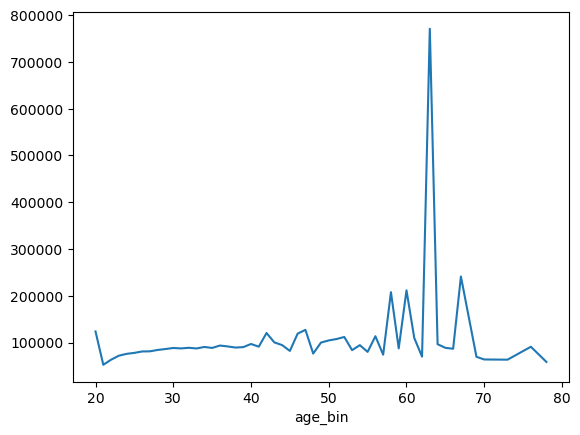

In [25]:
# Посмотрим на распределение среднего дохода в зависимости от возраста
df[df['person_age'] < 80].groupby('age_bin')['person_income'].mean().plot()

<Axes: xlabel='age_bin'>

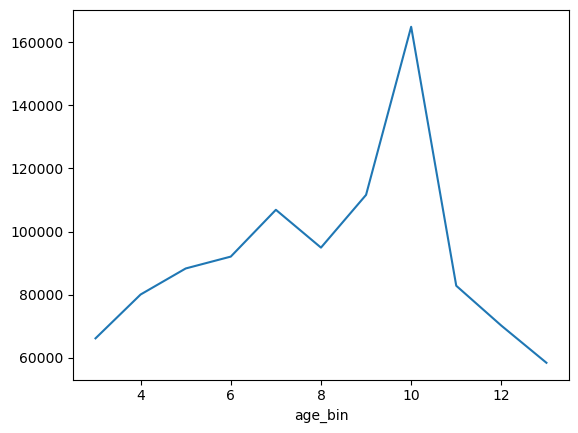

In [26]:
df['age_bin'] = df['person_age'] // 6
df[df['person_age'] < 80].groupby('age_bin')['person_income'].mean().plot()

Пропусков нет - скучно :(

In [27]:
from numpy import random
# зашумим часть данных для дальнейшего интереса :-)

# Зашумим случаный 1000 возрастов (может быть меньше с учетом коллизий индексов)
# Это даст нам случайное распределение пустот
df.loc[random.choice(range(df.shape[0]), 1000), 'person_age'] = np.nan

# Уберём значительную часть доходов у людей, которые хотят взять кредит на образование
# Это зашумление нам даст неслучайное смещение
df.loc[df[df['loan_intent'] == 'EDUCATION'].sample(3000).index, 'person_income'] = np.nan

In [28]:
df.isna().sum()


person_age                         992
person_gender                        0
person_education                     0
person_income                     3000
person_emp_exp                       0
person_home_ownership                0
loan_amnt                            0
loan_intent                          0
loan_int_rate                        0
loan_percent_income                  0
cb_person_cred_hist_length           0
credit_score                         0
previous_loan_defaults_on_file       0
loan_status                          0
age_bin                              0
dtype: int64

In [29]:
# Проверим гипотезы про случайность/неслучайность получившихся пустот

print('Target rate all:', df[TARGET].mean())

print('--'*20)

print('Target rate income null:', df[df['person_income'].isna()][TARGET].mean())
print('Target rate income not null:', df[df['person_income'].notna()][TARGET].mean())

print('--'*20)

print('Target rate age null:', df[df['person_age'].isna()][TARGET].mean())
print('Target rate age not null:', df[df['person_age'].notna()][TARGET].mean())

Target rate all: 0.2222222222222222
----------------------------------------
Target rate income null: 0.16533333333333333
Target rate income not null: 0.22628571428571428
----------------------------------------
Target rate age null: 0.2217741935483871
Target rate age not null: 0.2222323213961098


## Попробуем обучить LogisticRegression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [31]:
# Разобъем на тренировочную и тестовую выборки
train, test = train_test_split(df, test_size=0.25, random_state=43)

In [32]:
# Для простоты возьмём несколько числовых колонок в качестве факторов
features = ['loan_amnt', 'loan_int_rate'] # loan_amnt - сумма кредита, loan_int_rate - процентная ставка

In [33]:
X_train = train[features]
y_train = train[TARGET] #loan status - статус кредита (наш таргет)

X_test = test[features]
y_test = test[TARGET]

In [34]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [35]:
def least_squared_estimator(X, y, learn_intercept=False):
  X = np.array(X)
  if learn_intercept:
    X = np.concatenate([np.ones((X.shape[0], 1), ), X ], axis=1)
  coefs = np.linalg.inv(X.T @ X) @ X.T @ y
  return coefs

In [36]:
coefs = least_squared_estimator(X_train, y_train, learn_intercept=True)
f = lambda x: coefs[0] + coefs[1] * x[:, 0] + coefs[2] * x[:, 1]

print(f)

<function <lambda> at 0x0000018B2D7AD080>


In [37]:
coefs

array([-3.15807260e-01,  4.23973811e-06,  4.52734577e-02])

In [38]:
train['predict'] = lr.predict(X_train)
test['predict'] = lr.predict(X_test)


train['predict_proba'] = lr.predict_proba(X_train)[:, 1]
test['predict_proba'] = lr.predict_proba(X_test)[:, 1]

In [39]:
train['predict_naive'] = f(X_train.values)
test['predict_naive'] = f(X_test.values)

In [40]:
import matplotlib as mpl

train_sample = train.sample(2500)
test_sample = test.sample(2500)

print(train_sample)

       person_age person_gender person_education  person_income  \
25240        27.0        female         Bachelor        99895.0   
9198         24.0          male        Associate        73020.0   
24477        34.0          male      High School        88693.0   
40212        25.0          male        Associate        64528.0   
40074        27.0        female        Associate        72832.0   
...           ...           ...              ...            ...   
3587         25.0          male      High School        74247.0   
23805        33.0          male        Associate        53744.0   
19942        31.0        female        Associate        41846.0   
7221         22.0          male        Associate            NaN   
1540         23.0          male           Master        37363.0   

       person_emp_exp person_home_ownership  loan_amnt      loan_intent  \
25240               9              MORTGAGE     4000.0          VENTURE   
9198                0              MORTGAGE  

Посмотрим как мы попали на Train

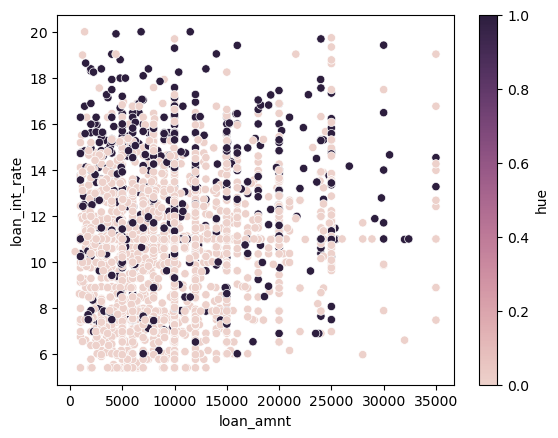

In [41]:
cmap = sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue=TARGET, hue_norm=sm.norm, palette= cmap, legend= False)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

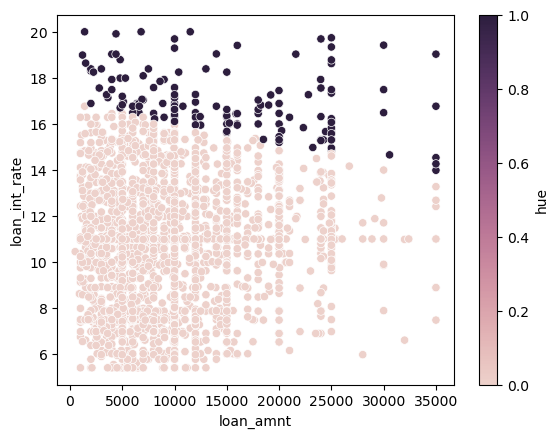

In [42]:
#плохой способ, predict 0,5
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='predict', hue_norm=sm.norm, palette= cmap, legend= False)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

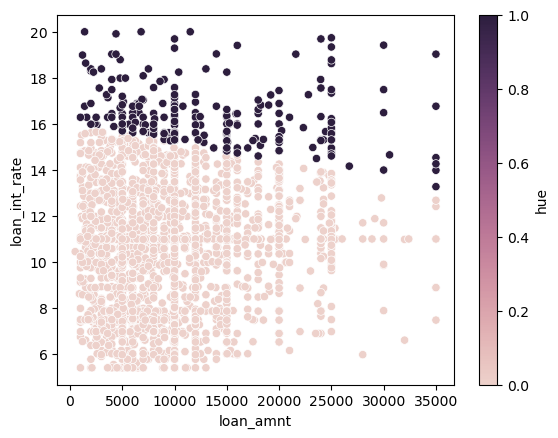

In [43]:
#хороший способ, порог настраиваем сами
train_sample['new_predict'] = (train_sample['predict_proba'] > 0.44).astype(int)
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='new_predict', hue_norm=sm.norm, palette= cmap, legend= False)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

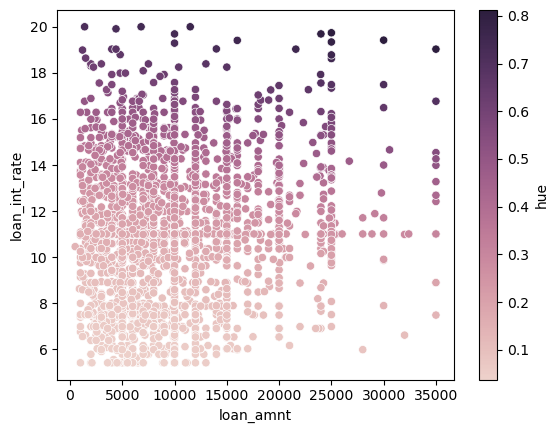

In [44]:
#градиент цвета, норм подход
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='predict_proba', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

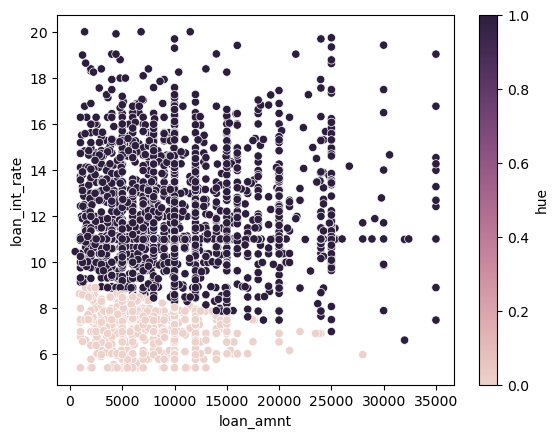

In [45]:
#наивный подход 
train_sample['new_predict'] = (train_sample['predict_naive'] > 0.1).astype(int)
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=train_sample, x='loan_amnt', y='loan_int_rate', hue='new_predict', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

Посмотрим как мы попали на Test

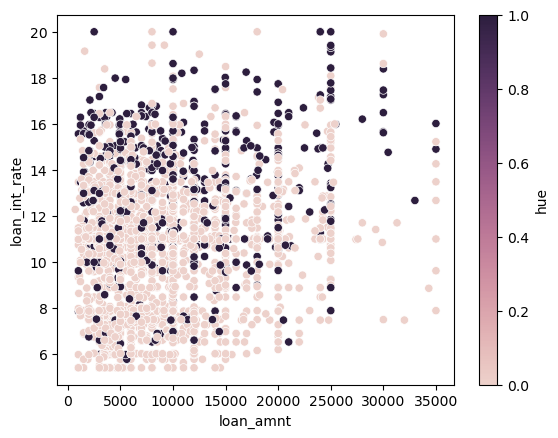

In [46]:
cmap = sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue=TARGET, hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

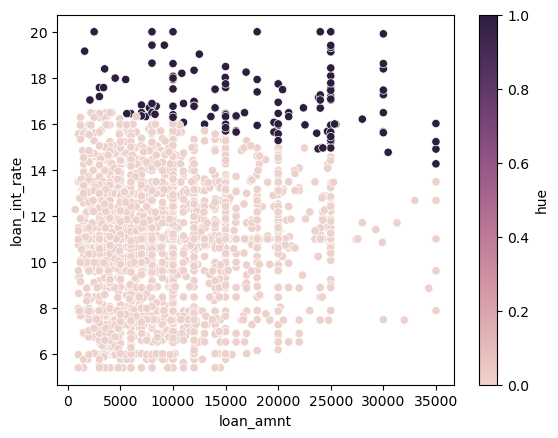

In [47]:
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='predict', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

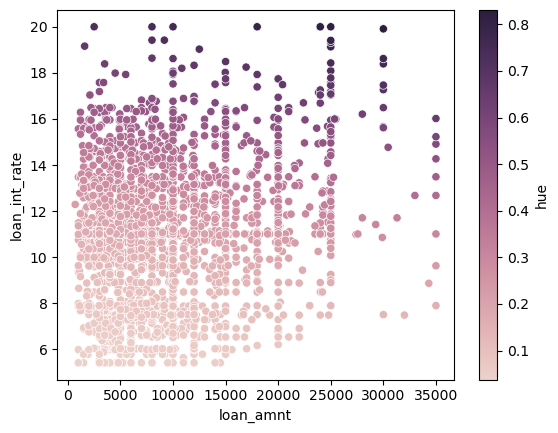

In [48]:
cmap= sns.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='predict_proba', hue_norm=sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('hue')

### Посчитаем Метрики

In [49]:
# Для начала заимпортим их
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

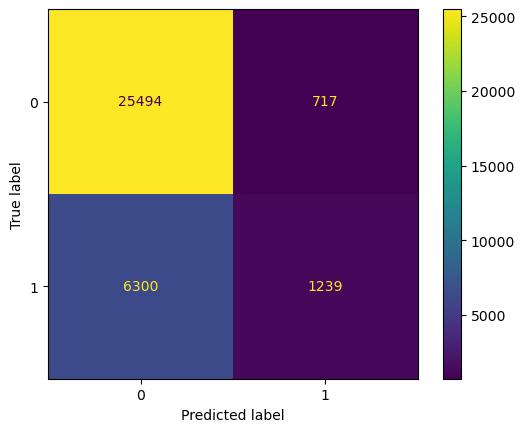

In [50]:
# Нарисуем Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(train[TARGET], train['predict'])).plot()

Верхняя левая (25494):
Истинный класс: 0
Предсказанный класс: 0
Значение: Это количество объектов, которые на самом деле относятся к классу 0, и модель правильно предсказала их как класс 0. Это Истинно Отрицательные (True Negatives, TN). Модель молодец.

Верхняя правая (717):
Истинный класс: 0
Предсказанный класс: 1
Значение: Это количество объектов, которые на самом деле относятся к классу 0, но модель ошибочно предсказала их как класс 1. Это Ложно Положительные (False Positives, FP), или "ошибка I рода". Модель ошиблась.

Нижняя левая (6300):
Истинный класс: 1
Предсказанный класс: 0
Значение: Это количество объектов, которые на самом деле относятся к классу 1, но модель ошибочно предсказала их как класс 0. Это Ложно Отрицательные (False Negatives, FN), или "ошибка II рода". Модель ошиблась (возможно, это самая критичная ошибка, если класс 1 - это что-то важное, например, болезнь).

Нижняя правая (1239):
Истинный класс: 1
Предсказанный класс: 1
Значение: Это количество объектов, которые на самом деле относятся к классу 1, и модель правильно предсказала их как класс 1. Это Истинно Положительные (True Positives, TP). Модель молодец.

In [51]:
# train
accuracy_score(train[TARGET], train['predict'])

0.7920888888888888

In [52]:
# train
accuracy_score(train[TARGET], [0] * train.shape[0])

0.7766222222222222

In [53]:
# test
accuracy_score(test[TARGET], test['predict'])

0.7953777777777777

In [54]:
accuracy_score(train[TARGET], (train['predict_proba'] > 0.44).astype(int))

0.7988740740740741

In [55]:
# train
precision_score(train[TARGET], train['predict'])

0.6334355828220859

In [56]:
# test
precision_score(test[TARGET], test['predict'])

0.6276083467094703

In [57]:
# train
recall_score(train[TARGET], train['predict'])

0.16434540389972144

In [58]:
# test
recall_score(test[TARGET], test['predict'])

0.1588785046728972

In [59]:
# train
roc_auc_score(train[TARGET], train['predict'])

0.5684952382895654

In [60]:
# test
roc_auc_score(test[TARGET], test['predict'])

0.5662409362595342

In [61]:
# train
roc_auc_score(train[TARGET], train['predict_proba'])

0.7223131917050427

In [62]:
# test
roc_auc_score(test[TARGET], test['predict_proba'])

0.7181920078610324

In [63]:
roc_auc_score(train[TARGET], train['predict_naive'])

0.7224718164513158

In [64]:
roc_auc_score(test[TARGET], test['predict_naive'])

0.7181826688628414

In [65]:
from tqdm.auto import tqdm
stats = []
for threshold in tqdm(np.linspace(0.01, 1, 100)):
    stats.append({
        'threshold': threshold,
        'accuracy': accuracy_score(train[TARGET], (train['predict_proba'] > threshold).astype(int)),
        'accuracy_naive': accuracy_score(train[TARGET], (train['predict_naive'] > threshold).astype(int)),
        'precision': precision_score(train[TARGET], (train['predict_proba'] > threshold).astype(int), zero_division=0),
        'precision_naive': precision_score(train[TARGET], (train['predict_naive'] > threshold).astype(int), zero_division=0),
        'recall': recall_score(train[TARGET], (train['predict_proba'] > threshold).astype(int), zero_division=0),
        'recall_naive': recall_score(train[TARGET], (train['predict_naive'] > threshold).astype(int), zero_division=0),
    })
stats = pd.DataFrame(stats)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: xlabel='threshold', ylabel='accuracy'>

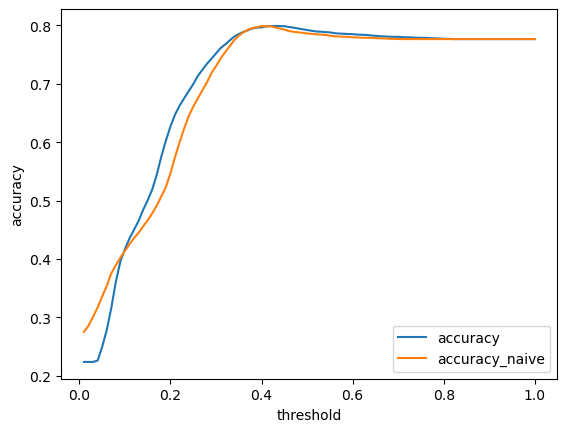

In [66]:
sns.lineplot(data=stats, x='threshold', y='accuracy', label='accuracy')
sns.lineplot(data=stats, x='threshold', y='accuracy_naive',  label='accuracy_naive')

<Axes: xlabel='threshold', ylabel='precision'>

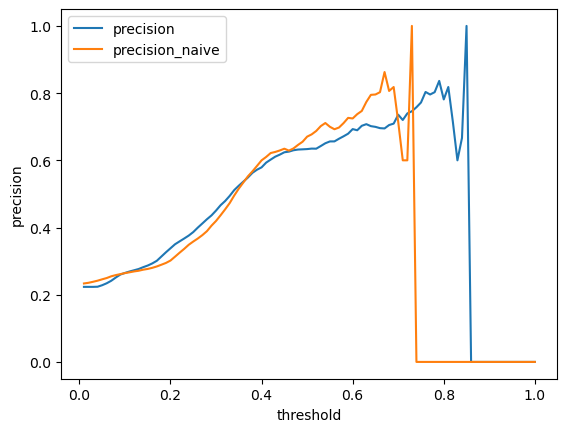

In [67]:
sns.lineplot(data=stats, x='threshold', y='precision', label='precision')
sns.lineplot(data=stats, x='threshold', y='precision_naive',  label='precision_naive')

<Axes: xlabel='threshold', ylabel='recall'>

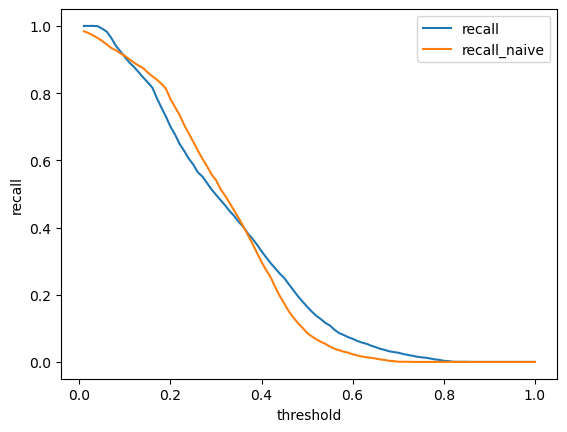

In [68]:
sns.lineplot(data=stats, x='threshold', y='recall', label='recall')
sns.lineplot(data=stats, x='threshold', y='recall_naive',  label='recall_naive')

### Таргет рейт в бинах скоров модели (калибровка)

In [69]:
# Посчитаем равномерные бины по скору на train
_, bins = pd.qcut(train['predict_proba'], q=20, retbins=True)

# Пременим их к train и test
train['proba_bin'] = pd.cut(train['predict_proba'], bins=bins)
test['proba_bin'] = pd.cut(test['predict_proba'], bins=bins)

In [70]:
# Внутри бинов посчитаем средний таргет и среднюю predict_proba
train_stats = train.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()
display(train_stats)

C:\Users\evoni\AppData\Local\Temp\ipykernel_57384\2213546392.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_stats = train.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()


,predict_proba,loan_status
proba_bin,,
"(0.0377, 0.0567]",0.048403,0.060534
"(0.0567, 0.068]",0.062784,0.086002
"(0.068, 0.0776]",0.073074,0.090372
"(0.0776, 0.0884]",0.082339,0.089994
"(0.0884, 0.106]",0.096756,0.138361
"(0.106, 0.129]",0.117001,0.137173
"(0.129, 0.149]",0.139000,0.140828
"(0.149, 0.166]",0.158549,0.145294
"(0.166, 0.178]",0.171868,0.172146


In [71]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

# Create a base model and fit it first
base_model = LogisticRegression()
base_model.fit(train[['predict_proba']], train[TARGET])

# Create a calibration model with the fitted estimator
calibration = CalibratedClassifierCV(estimator=base_model, cv='prefit')
# Fit the calibration model
calibration.fit(train[['predict_proba']], train[TARGET])

# Use the calibrated model to predict probabilities
train['predict_proba_calib'] = calibration.predict_proba(train[['predict_proba']])[:, 1]
test['predict_proba_calib'] = calibration.predict_proba(test[['predict_proba']])[:, 1]

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(-2.5, 0, ''),
  Text(0.0, 0, '(0.0377, 0.0567]'),
  Text(2.5, 0, ''),
  Text(5.0, 0, '(0.106, 0.129]'),
  Text(7.5, 0, ''),
  Text(10.0, 0, '(0.19, 0.203]'),
  Text(12.5, 0, ''),
  Text(15.0, 0, '(0.299, 0.332]'),
  Text(17.5, 0, ''),
  Text(20.0, 0, '')])

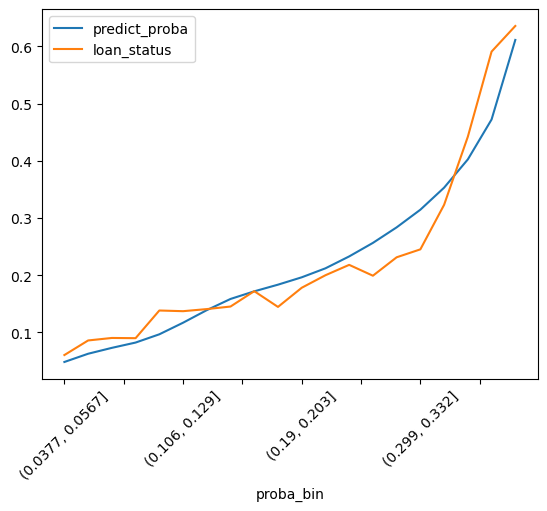

In [72]:
train_stats.plot()
plt.xticks(rotation=45)

C:\Users\evoni\AppData\Local\Temp\ipykernel_57384\1045931144.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_stats = test.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(-2.5, 0, ''),
  Text(0.0, 0, '(0.0377, 0.0567]'),
  Text(2.5, 0, ''),
  Text(5.0, 0, '(0.106, 0.129]'),
  Text(7.5, 0, ''),
  Text(10.0, 0, '(0.19, 0.203]'),
  Text(12.5, 0, ''),
  Text(15.0, 0, '(0.299, 0.332]'),
  Text(17.5, 0, ''),
  Text(20.0, 0, '')])

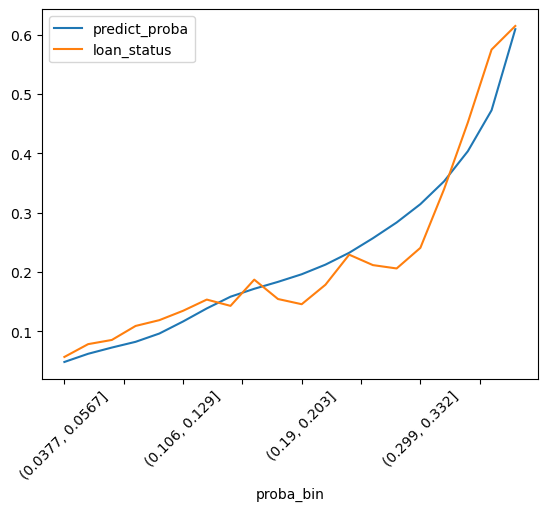

In [73]:
valid_stats = test.groupby(['proba_bin'])[['predict_proba', TARGET]].mean()
valid_stats.plot()
plt.xticks(rotation=45)

# Домашнее Задание

In [74]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

## Logistic Regression (Своими Силами)

1. Дописать код градиентного спуска ниже
2. Поиграться с датасетом, предложеннным выше
3. Построить свою версию Логистической регресии (на каком-то одном числовом факторе без пропусков), сравнить результаты с LogisticRegression из SKlearn (Оценить метрики - ROC AUC, подобрать порог и Построить Confusion Matrix, а так же производные метрики от неё )
4. Заполнить пропуски, обработать категориальные переменные, обучить свою версию модели и Logistic Regression, сравнить качество между ними (см п.3) + с моделями из п.3 (как добавление бОльшего количества факторов влияет на качество модели)
5. *Поиграться с нормировкой данных (sklearn.model_selection.StandardScaler) оценить эффект на веса модели и её качество
6. Разбить факторы на Клиентские/Продуктовые/Кредитная История и построить по одной модели на каждом факторе. Затем построить мета-модель (интегральная модель) на трёх факторах - скорах метамоделях (дрейверы) - Сравнить результаты по каждому из драйеров + интегральной модели с одной моделью на всём факторном прстранстве.
7. *Привести график качества (ROC AUC) модели на фиксированной тренировочной выборке в зависимости от количества наблюдений, которые используются при обучении (train выборка). Например: 100, 500, 1000 и тд.

*- задания со звёздочкой, не обязательно, но довольно интересные

In [75]:
def sigmoid(z):
  z = np.clip(z, -500, 500)
  return 1 / (1 + np.exp(-z))

def logloss(w, X, y):
    return np.log2(1 + np.exp(-(X @ w)*y)).mean()

In [ ]:
# Реализуем собственный класс логистической регрессии
class MyLogisticRegression:
    def __init__(self, lr=1e-4, bias=True):
      self.bias = bool(bias)
      self.weights = None
      self.lr = lr

    def preproc_x(self, X):
      # Добавляем bias если требуется
      return np.hstack([np.ones((X.shape[0], 1)), X]) if self.bias else X

    def fit(self, X, y, c_epoch=1000):
      # Инициализируем веса
      self.weights = np.ones(X.shape[1]+self.bias)

      self.X = self.preproc_x(X)
      self.y = y


      # Стохастический градиентный спуск
      # Итерируемся по количеству эпох
      for i in range(c_epoch):
        # Перешмешиваем наблюдения случайным образом
        ids = list(range(self.X.shape[0]))
        np.random.shuffle(ids)

        # итерируемся по наблюдениям
        for j in ids:
          p = sigmoid(np.dot(self.X[j], self.weights))
          # !TODO: Реализовать самостоятельно
          self.weights += self.lr * (self.y[j] - p) * self.X[j]

        print(i , ':', logloss(self.weights, self.X, self.y))

    def predict_proba(self, X):
      X = self.preproc_x(X)
      return sigmoid((X @ self.weights)*1)

    def predict(self, X, threshold = 0.5):
      # X = self.preproc_x(X)
      # preds = (sigmoid((X @ self.weights)*1) > 0.5).astype(int)
      # preds[preds == 0] = -1
      probs = self.predict_proba(X)
      
      return (probs > threshold).astype(int)

### ВРЕМЕННО: ВТОРАЯ ВЕРСИЯ МОЕЙ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

In [93]:
# def sigmoid(z):
#     z = np.clip(z, -500, 500)
#     pos_mask = (z >= 0)
#     neg_mask = ~pos_mask
    
#     result = np.zeros_like(z)
#     result[pos_mask] = 1.0 / (1.0 + np.exp(-z[pos_mask]))
#     exp_z = np.exp(z[neg_mask])
#     result[neg_mask] = exp_z / (1.0 + exp_z)
    
#     return result
  
  
# class MyLogisticRegression:
#   def __init__(self, lr=1e-4, bias=True):
#     self.bias = bool(bias)
#     self.weights = None
#     self.lr = lr
#     self.loss_history = []
    
      
#   def _add_intercept(self, X):
#       if self.bias:
#           intercept = np.ones((X.shape[0], 1))
#           return np.concatenate((intercept, X), axis=1)
#       return X

#   def preproc_x(self, X):
#     # Добавляем bias если требуется
#     return np.hstack([np.ones((X.shape[0], 1)), X]) if self.bias else X

#   def fit(self, X, y, c_epoch=100):
#     X_copy = np.array(X, dtype=np.float64)
#     y_binary = (y + 1) / 2 if np.any(y == -1) else y
    
#     # Добавляем столбец из единиц для bias term
#     X_proc = self._add_intercept(X_copy)
    
#     n_samples, n_features = X_proc.shape
    
#     # Инициализируем веса малыми случайными значениями ОДИН РАЗ
#     self.weights = np.random.randn(n_features) * 0.01
    
#     batch_size = min(200, n_samples)  # Размер мини-батча
    
#     # Итерируемся по количеству эпох
#     for epoch in range(c_epoch):
#         # Перемешиваем наблюдения случайным образом
#         indices = np.random.permutation(n_samples)
#         X_shuffled = X_proc[indices]
#         y_shuffled = y_binary[indices]
        
#         # Итерируемся по мини-батчам
#         for i in range(0, n_samples, batch_size):
#             end = min(i + batch_size, n_samples)
#             X_batch = X_shuffled[i:end]
#             y_batch = y_shuffled[i:end]
            
#             # Прогноз
#             predictions = sigmoid(X_batch @ self.weights)
            
#             # Вычисляем градиент на батче
#             errors = predictions - y_batch
#             gradients = X_batch.T @ errors / len(X_batch)
            
#             # Обновляем веса
#             self.weights -= self.lr * gradients
        
#         # Вычисляем текущую функцию потерь
#         current_loss = self._compute_loss(X_proc, y_binary)
#         self.loss_history.append(current_loss)
        
#         # Печатаем прогресс
#         if epoch % 100 == 0:
#             print(f"Epoch {epoch}, Loss: {current_loss:.6f}")
    
#     return self

#   def _compute_loss(self, X, y):
#     """Вычисляет функцию потерь (логистическую)"""
#     z = X @ self.weights
    
#     # Стабильное вычисление потерь
#     pos_mask = z >= 0
    
#     # Для y=1
#     pos_class = (y == 1)
#     log_pos_loss = np.zeros_like(z)
#     log_pos_loss[pos_mask & pos_class] = np.log1p(np.exp(-z[pos_mask & pos_class]))
#     log_pos_loss[~pos_mask & pos_class] = -z[~pos_mask & pos_class] + np.log1p(np.exp(z[~pos_mask & pos_class]))
    
#     # Для y=0
#     neg_class = (y == 0)
#     log_neg_loss = np.zeros_like(z)
#     log_neg_loss[pos_mask & neg_class] = z[pos_mask & neg_class] + np.log1p(np.exp(-z[pos_mask & neg_class]))
#     log_neg_loss[~pos_mask & neg_class] = np.log1p(np.exp(z[~pos_mask & neg_class]))
    
#     # Общие потери
#     loss = np.mean(log_pos_loss + log_neg_loss)
#     return loss

#   def predict_proba(self, X):
#     X_proc = self.preproc_x(X)
#     return sigmoid(X_proc @ self.weights)

#   def predict(self, X):
#     # X_proc = self.preproc_x(X)
#     # return (self.predict_proba(X) > 0.5).astype(int)
#     return (self.predict_proba(X) > 0.5).astype(int) 

### ВРЕМЕННАЯ ВЕРСИЯ РЕГРЕССИИ

In [94]:
# import numpy as np
# import matplotlib.pyplot as plt

# class FixedLogisticRegression:
#     """
#     Полностью переписанная реализация логистической регрессии
#     с защитой от числовой нестабильности и чистым кодом
#     """
#     def __init__(self, learning_rate=0.01, max_iterations=1000, tol=1e-4, 
#                  fit_intercept=True, verbose=True):
#         self.learning_rate = learning_rate
#         self.max_iterations = max_iterations
#         self.tol = tol
#         self.fit_intercept = fit_intercept
#         self.verbose = verbose
#         self.weights = None
#         self.loss_history = []
    
#     def _add_intercept(self, X):
#         """Добавляет столбец из единиц для bias/intercept"""
#         if self.fit_intercept:
#             intercept = np.ones((X.shape[0], 1))
#             return np.concatenate((intercept, X), axis=1)
#         return X
    
#     def _sigmoid(self, z):
#         """
#         Стабильная реализация сигмоиды
#         Обрабатывает как положительные, так и отрицательные значения z
#         """
#         # Обрезаем очень большие/маленькие значения для стабильности
#         z = np.clip(z, -500, 500)
        
#         # Более эффективная и численно стабильная реализация
#         pos_mask = (z >= 0)
#         neg_mask = ~pos_mask
        
#         result = np.zeros_like(z)
#         result[pos_mask] = 1.0 / (1.0 + np.exp(-z[pos_mask]))
        
#         # Для отрицательных значений используем математически эквивалентную,
#         # но численно более стабильную формулу
#         exp_z = np.exp(z[neg_mask])
#         result[neg_mask] = exp_z / (1.0 + exp_z)
        
#         return result
    
#     def _compute_cost(self, X, y, weights):
#         """
#         Вычисляет бинарную кросс-энтропию (логистическую функцию потерь)
#         с защитой от числовой нестабильности
#         """
#         m = X.shape[0]
        
#         # Вычисляем прогнозы
#         z = X @ weights
        
#         # Стабильное вычисление потерь
#         # Используем альтернативное вычисление для положительных и отрицательных z
#         pos_idx = z >= 0
#         neg_idx = ~pos_idx
        
#         log_probs = np.zeros_like(z)
        
#         # Для положительных z:
#         # -log(sigmoid(z)) = -log(1/(1+exp(-z))) = log(1+exp(-z))
#         log_probs[pos_idx & (y==1)] = np.log1p(np.exp(-z[pos_idx & (y==1)]))
        
#         # Для отрицательных z:
#         # -log(sigmoid(z)) = -log(exp(z)/(1+exp(z))) = -z + log(1+exp(z))
#         log_probs[neg_idx & (y==1)] = -z[neg_idx & (y==1)] + np.log1p(np.exp(z[neg_idx & (y==1)]))
        
#         # 1-y=1 => y=0, -log(1-sigmoid(z)) = -log((1+exp(-z)-1)/(1+exp(-z))) = -log(exp(-z)/(1+exp(-z)))
#         # = z + log(1+exp(-z))
#         log_probs[pos_idx & (y==0)] = z[pos_idx & (y==0)] + np.log1p(np.exp(-z[pos_idx & (y==0)]))
        
#         # Для отрицательных z:
#         # -log(1-sigmoid(z)) = -log(1-exp(z)/(1+exp(z))) = -log((1+exp(z)-exp(z))/(1+exp(z))) 
#         # = -log(1/(1+exp(z))) = log(1+exp(z))
#         log_probs[neg_idx & (y==0)] = np.log1p(np.exp(z[neg_idx & (y==0)]))
        
#         # Средние потери
#         cost = np.mean(log_probs)
        
#         # Добавим регуляризацию L2 (Ridge), если нужно
#         # cost += (self.alpha / (2 * m)) * np.sum(weights[1:] ** 2)
        
#         return cost
    
#     def fit(self, X, y):
#         """
#         Обучает модель, используя мини-батч градиентный спуск
#         X: array-like, признаки размером (n_samples, n_features)
#         y: array-like, метки размером (n_samples,)
#         """
#         X_copy = np.array(X, dtype=np.float64)
#         y_copy = np.array(y, dtype=np.float64)
        
#         # Добавляем столбец из единиц для bias term
#         X_with_intercept = self._add_intercept(X_copy)
        
#         n_samples, n_features = X_with_intercept.shape
        
#         # Инициализируем веса малыми случайными значениями
#         self.weights = np.random.randn(n_features) * 0.01
        
#         batch_size = min(200, n_samples)  # Размер мини-батча
        
#         # Основной цикл обучения
#         for iteration in range(self.max_iterations):
#             # Перемешиваем данные на каждой итерации
#             indices = np.random.permutation(n_samples)
#             X_shuffled = X_with_intercept[indices]
#             y_shuffled = y_copy[indices]
            
#             # Обучение по мини-батчам
#             for i in range(0, n_samples, batch_size):
#                 end = min(i + batch_size, n_samples)
#                 X_batch = X_shuffled[i:end]
#                 y_batch = y_shuffled[i:end]
                
#                 # Прогноз (вероятность принадлежности к классу 1)
#                 predictions = self._sigmoid(X_batch @ self.weights)
                
#                 # Вычисляем градиент
#                 errors = predictions - y_batch
#                 gradients = X_batch.T @ errors / len(X_batch)
                
#                 # Обновляем веса
#                 self.weights -= self.learning_rate * gradients
            
#             # Вычисляем потери на всем наборе данных
#             cost = self._compute_cost(X_with_intercept, y_copy, self.weights)
#             self.loss_history.append(cost)
            
#             # Выводим прогресс каждые 100 итераций, если verbose=True
#             if self.verbose and (iteration % 100 == 0 or iteration == self.max_iterations - 1):
#                 print(f"Iteration {iteration}, Cost: {cost:.6f}")
            
#             # Проверяем условие ранней остановки
#             if iteration > 0 and abs(self.loss_history[-1] - self.loss_history[-2]) < self.tol:
#                 if self.verbose:
#                     print(f"Converged at iteration {iteration}")
#                 break
        
#         return self
    
#     def predict_proba(self, X):
#         """
#         Предсказывает вероятности принадлежности к классу 1
#         X: array-like, признаки размером (n_samples, n_features)
#         Returns: array, вероятности размером (n_samples,)
#         """
#         if self.weights is None:
#             raise ValueError("Model has not been trained yet.")
        
#         X_copy = np.array(X, dtype=np.float64)
#         X_with_intercept = self._add_intercept(X_copy)
        
#         return self._sigmoid(X_with_intercept @ self.weights)
    
#     def predict(self, X, threshold=0.5):
#         """
#         Предсказывает классы, используя пороговое значение
#         X: array-like, признаки размером (n_samples, n_features)
#         threshold: float, порог для классификации (по умолчанию 0.5)
#         Returns: array, предсказанные классы размером (n_samples,)
#         """
#         return (self.predict_proba(X) >= threshold).astype(int)
    
#     def score(self, X, y):
#         """
#         Возвращает accuracy score на данных X и y
#         """
#         return np.mean(self.predict(X) == y)
    
#     def plot_loss_history(self):
#         """
#         Визуализирует историю потерь
#         """
#         plt.figure(figsize=(10, 6))
#         plt.plot(range(len(self.loss_history)), self.loss_history)
#         plt.title('Loss History')
#         plt.xlabel('Iteration')
#         plt.ylabel('Loss')
#         plt.grid(True)
#         plt.show()



In [95]:
# # Импортируем необходимые библиотеки
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# # Предполагаем, что ваши данные уже разделены на train и test, и TARGET уже определен
# # Если нет, то нужно добавить код разделения данных

# # 1. Обработка пропусков в данных 
# # Заполняем пропуски в числовых признаках медианными значениями
# features = ['loan_amnt', 'loan_int_rate']
# imputer = SimpleImputer(strategy='median')

# # Применяем импьютеры к train и test отдельно
# X_train = imputer.fit_transform(train[features])
# X_test = imputer.transform(test[features])
# y_train = train[TARGET].values
# y_test = test[TARGET].values

# # 2. Нормализация данных - КРИТИЧЕСКИ ВАЖНО!
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 3. Обучение вашей улучшенной модели
# my_lr = FixedLogisticRegression(learning_rate=0.01, max_iterations=1000)
# my_lr.fit(X_train_scaled, y_train)

# # 4. Обучение модели из sklearn для сравнения
# sk_lr = LogisticRegression(max_iter=1000)
# sk_lr.fit(X_train_scaled, y_train)

# # 5. Получение предсказаний
# # Ваша модель
# train['my_predict'] = my_lr.predict(X_train_scaled)
# train['my_predict_proba'] = my_lr.predict_proba(X_train_scaled)
# test['my_predict'] = my_lr.predict(X_test_scaled)
# test['my_predict_proba'] = my_lr.predict_proba(X_test_scaled)

# # Модель sklearn
# train['sk_predict'] = sk_lr.predict(X_train_scaled)
# train['sk_predict_proba'] = sk_lr.predict_proba(X_train_scaled)[:, 1]
# test['sk_predict'] = sk_lr.predict(X_test_scaled)
# test['sk_predict_proba'] = sk_lr.predict_proba(X_test_scaled)[:, 1]

# # 6. Сравниваем веса моделей
# print("MyLogisticRegression weights:", my_lr.weights)
# print("Sklearn LogisticRegression weights:", np.append(sk_lr.intercept_, sk_lr.coef_[0]))

# # 7. Оцениваем качество моделей
# metrics = {}
# models = ['my', 'sk']

# for model in models:
#     metrics[model] = {
#         'accuracy': accuracy_score(test[TARGET], test[f'{model}_predict']),
#         'precision': precision_score(test[TARGET], test[f'{model}_predict']),
#         'recall': recall_score(test[TARGET], test[f'{model}_predict']),
#         'roc_auc': roc_auc_score(test[TARGET], test[f'{model}_predict_proba'])
#     }

# # Выводим метрики в виде таблицы
# metrics_df = pd.DataFrame(metrics).T
# print("\nMetrics comparison:")
# print(metrics_df)

# # 8. Визуализируем историю обучения
# my_lr.plot_loss_history()

# # 9. Строим матрицы ошибок
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# ConfusionMatrixDisplay(confusion_matrix(test[TARGET], test['my_predict'])).plot(ax=axes[0])
# axes[0].set_title('MyLogisticRegression')
# ConfusionMatrixDisplay(confusion_matrix(test[TARGET], test['sk_predict'])).plot(ax=axes[1])
# axes[1].set_title('Sklearn LogisticRegression')
# plt.tight_layout()
# plt.show()

# # 10. Визуализируем распределение предсказанных вероятностей
# plt.figure(figsize=(10, 5))
# plt.hist(test['my_predict_proba'], bins=50, alpha=0.5, label='My LogReg')
# plt.hist(test['sk_predict_proba'], bins=50, alpha=0.5, label='Sklearn LogReg')
# plt.title('Probability Distributions')
# plt.xlabel('Predicted Probability')
# plt.ylabel('Count')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 11. Построение scatter-plot для визуализации
# test_sample = test.sample(2500)
# plt.figure(figsize=(15, 10))

# # Создаем сетку для 2x2 графиков
# plt.subplot(2, 2, 1)
# from matplotlib import colors

# cmap = sns.color_palette('ch:', as_cmap=True)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.Normalize())
# scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue=TARGET, 
#                          hue_norm=sm.norm, palette=cmap)
# plt.colorbar(sm, ax=plt.gca()).set_label('Target')
# plt.title('Actual Target Values')

# plt.subplot(2, 2, 2)
# scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='my_predict_proba', 
#                          hue_norm=sm.norm, palette=cmap)
# plt.colorbar(sm, ax=plt.gca()).set_label('My LogReg Probability')
# plt.title('MyLogisticRegression Probabilities')

# plt.subplot(2, 2, 3)
# scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='sk_predict_proba', 
#                          hue_norm=sm.norm, palette=cmap)
# plt.colorbar(sm, ax=plt.gca()).set_label('Sklearn LogReg Probability')
# plt.title('Sklearn LogisticRegression Probabilities')

# plt.subplot(2, 2, 4)
# # Сравнение предсказаний
# comparison = []
# for _, row in test_sample.iterrows():
#     if row['my_predict'] == row['sk_predict'] == row[TARGET]:
#         comparison.append('Both Correct')
#     elif row['my_predict'] == row[TARGET] and row['sk_predict'] != row[TARGET]:
#         comparison.append('My Correct')
#     elif row['my_predict'] != row[TARGET] and row['sk_predict'] == row[TARGET]:
#         comparison.append('Sklearn Correct')
#     else:
#         comparison.append('Both Wrong')

# test_sample['comparison'] = comparison
# scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='comparison', 
#                          palette={'Both Correct': 'green', 'My Correct': 'blue', 
#                                   'Sklearn Correct': 'orange', 'Both Wrong': 'red'})
# plt.title('Comparison of Predictions')
# plt.legend(title='Prediction Comparison')

# plt.tight_layout()
# plt.show()

### ------------------------

### [temporarily] PureSGDLogisticRegression Тесты для модели SGD логистической регрессии

In [96]:
# # Импортируем необходимые библиотеки
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# # Реализация чистого SGD для логистической регрессии
# class PureSGDLogisticRegression:
#     """
#     Реализация логистической регрессии с использованием чистого стохастического 
#     градиентного спуска (по одному примеру) для бинарной классификации.
#     """
    
#     def __init__(self, learning_rate=0.01, max_iterations=1000, random_state=None):
#         """
#         Инициализация параметров модели.
#         """
#         self.learning_rate = learning_rate
#         self.max_iterations = max_iterations
#         self.random_state = random_state
#         self.weights = None
#         self.bias = None
#         self.loss_history = []
        
#     def _sigmoid(self, z):
#         """
#         Сигмоидная функация активации.
#         """
#         # Ограничиваем z для предотвращения переполнения
#         z = np.clip(z, -500, 500)
#         return 1 / (1 + np.exp(-z))
    
#     def _initialize_parameters(self, n_features):
#         """
#         Инициализация весов и смещения.
#         """
#         np.random.seed(self.random_state)
#         self.weights = np.random.randn(n_features) * 0.01
#         self.bias = 0.0
    
#     def fit(self, X, y):
#         """
#         Обучение модели с использованием чистого стохастического градиентного спуска.
#         Каждый пример используется отдельно для обновления весов.
#         """
#         n_samples, n_features = X.shape
        
#         # Инициализация параметров
#         self._initialize_parameters(n_features)
        
#         # Создание генератора случайных чисел для перемешивания
#         rng = np.random.RandomState(self.random_state)
        
#         # Обучение в течение заданного количества итераций
#         for iteration in range(self.max_iterations):
#             # Перемешиваем индексы данных в каждой эпохе
#             indices = rng.permutation(n_samples)
#             X_shuffled = X[indices]
#             y_shuffled = y[indices]
            
#             # Проходим по каждому примеру отдельно (чистый SGD)
#             for i in range(n_samples):
#                 # Берем один пример
#                 x_i = X_shuffled[i:i+1]
#                 y_i = y_shuffled[i:i+1]
                
#                 # Прямой проход (предсказание)
#                 z = np.dot(x_i, self.weights) + self.bias
#                 y_pred = self._sigmoid(z)
                
#                 # Вычисление градиентов для одного примера
#                 dw = np.dot(x_i.T, (y_pred - y_i))
#                 db = np.sum(y_pred - y_i)
                
#                 # Обновление параметров для каждого примера
#                 self.weights -= self.learning_rate * dw
#                 self.bias -= self.learning_rate * db
            
#             # Вычисление функции потерь для всего набора данных после каждой эпохи
#             y_pred_all = self.predict_proba(X)
#             # Log loss вычисление
#             epsilon = 1e-15
#             y_pred_all = np.clip(y_pred_all, epsilon, 1 - epsilon)
#             loss = -np.mean(y * np.log(y_pred_all) + (1 - y) * np.log(1 - y_pred_all))
#             self.loss_history.append(loss)
            
#             # Вывод прогресса через каждые 100 итераций
#             if (iteration + 1) % 100 == 0:
#                 print(f"Итерация {iteration + 1}/{self.max_iterations}, Loss: {loss:.6f}")
        
#         return self
    
#     def predict_proba(self, X):
#         """
#         Предсказание вероятностей принадлежности к положительному классу.
#         """
#         z = np.dot(X, self.weights) + self.bias
#         return self._sigmoid(z)
    
#     def predict(self, X, threshold=0.5):
#         """
#         Предсказание меток классов.
#         """
#         return (self.predict_proba(X) >= threshold).astype(int)
    
#     def plot_loss_history(self):
#         """
#         Визуализирует историю функции потерь в процессе обучения.
#         """
#         plt.figure(figsize=(10, 6))
#         plt.plot(range(1, len(self.loss_history) + 1), self.loss_history)
#         plt.xlabel('Эпоха')
#         plt.ylabel('Функция потерь')
#         plt.title('История функции потерь')
#         plt.grid(True)
#         plt.tight_layout()


# # Предполагаем, что ваши данные уже разделены на train и test, и TARGET уже определен
# # Если нет, то нужно добавить код разделения данных

# # 1. Обработка пропусков в данных 
# # Заполняем пропуски в числовых признаках медианными значениями
# features = ['loan_amnt', 'loan_int_rate']
# imputer = SimpleImputer(strategy='median')

# # Применяем импьютеры к train и test отдельно
# X_train = imputer.fit_transform(train[features])
# X_test = imputer.transform(test[features])
# y_train = train[TARGET].values
# y_test = test[TARGET].values

# # 2. Нормализация данных - КРИТИЧЕСКИ ВАЖНО!
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 3. Обучение чистого SGD логистической регрессии
# print("\nОбучение модели PureSGDLogisticRegression...")
# my_lr = PureSGDLogisticRegression(
#     learning_rate=0.01, 
#     max_iterations=10,
#     random_state=42
# )
# my_lr.fit(X_train_scaled, y_train)

# # 4. Обучение модели из sklearn для сравнения
# print("\nОбучение модели из sklearn...")
# sk_lr = LogisticRegression(max_iter=10)
# sk_lr.fit(X_train_scaled, y_train)

# # 5. Получение предсказаний
# # Наша модель
# train['my_predict'] = my_lr.predict(X_train_scaled)
# train['my_predict_proba'] = my_lr.predict_proba(X_train_scaled)
# test['my_predict'] = my_lr.predict(X_test_scaled)
# test['my_predict_proba'] = my_lr.predict_proba(X_test_scaled)

# # Модель sklearn
# train['sk_predict'] = sk_lr.predict(X_train_scaled)
# train['sk_predict_proba'] = sk_lr.predict_proba(X_train_scaled)[:, 1]
# test['sk_predict'] = sk_lr.predict(X_test_scaled)
# test['sk_predict_proba'] = sk_lr.predict_proba(X_test_scaled)[:, 1]

# # 6. Сравниваем веса моделей
# print("PureSGDLogisticRegression weights:", my_lr.weights)
# print("Sklearn LogisticRegression weights:", np.append(sk_lr.intercept_, sk_lr.coef_[0]))

# # 7. Оцениваем качество моделей
# metrics = {}
# models = ['my', 'sk']

# for model in models:
#     metrics[model] = {
#         'accuracy': accuracy_score(test[TARGET], test[f'{model}_predict']),
#         'precision': precision_score(test[TARGET], test[f'{model}_predict']),
#         'recall': recall_score(test[TARGET], test[f'{model}_predict']),
#         'roc_auc': roc_auc_score(test[TARGET], test[f'{model}_predict_proba'])
#     }

# # Выводим метрики в виде таблицы
# metrics_df = pd.DataFrame(metrics).T
# metrics_df.index = ['PureSGDLogisticRegression', 'Sklearn LogisticRegression']
# print("\nMetrics comparison:")
# print(metrics_df)

# # 8. Визуализируем историю обучения
# my_lr.plot_loss_history()
# plt.show()

# # 9. Строим матрицы ошибок
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# ConfusionMatrixDisplay(confusion_matrix(test[TARGET], test['my_predict'])).plot(ax=axes[0])
# axes[0].set_title('PureSGDLogisticRegression')
# ConfusionMatrixDisplay(confusion_matrix(test[TARGET], test['sk_predict'])).plot(ax=axes[1])
# axes[1].set_title('Sklearn LogisticRegression')
# plt.tight_layout()
# plt.show()

# # 10. Визуализируем распределение предсказанных вероятностей
# plt.figure(figsize=(10, 5))
# plt.hist(test['my_predict_proba'], bins=50, alpha=0.5, label='Pure SGD LogReg')
# plt.hist(test['sk_predict_proba'], bins=50, alpha=0.5, label='Sklearn LogReg')
# plt.title('Probability Distributions')
# plt.xlabel('Predicted Probability')
# plt.ylabel('Count')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 11. Построение scatter-plot для визуализации
# test_sample = test.sample(2500)
# plt.figure(figsize=(15, 10))

# # Создаем сетку для 2x2 графиков
# plt.subplot(2, 2, 1)
# from matplotlib import colors

# cmap = sns.color_palette('ch:', as_cmap=True)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.Normalize())
# scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue=TARGET, 
#                          hue_norm=sm.norm, palette=cmap)
# plt.colorbar(sm, ax=plt.gca()).set_label('Target')
# plt.title('Actual Target Values')

# plt.subplot(2, 2, 2)
# scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='my_predict_proba', 
#                          hue_norm=sm.norm, palette=cmap)
# plt.colorbar(sm, ax=plt.gca()).set_label('Pure SGD LogReg Probability')
# plt.title('PureSGDLogisticRegression Probabilities')

# plt.subplot(2, 2, 3)
# scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='sk_predict_proba', 
#                          hue_norm=sm.norm, palette=cmap)
# plt.colorbar(sm, ax=plt.gca()).set_label('Sklearn LogReg Probability')
# plt.title('Sklearn LogisticRegression Probabilities')

# plt.subplot(2, 2, 4)
# # Сравнение предсказаний
# comparison = []
# for _, row in test_sample.iterrows():
#     if row['my_predict'] == row['sk_predict'] == row[TARGET]:
#         comparison.append('Both Correct')
#     elif row['my_predict'] == row[TARGET] and row['sk_predict'] != row[TARGET]:
#         comparison.append('SGD Correct')
#     elif row['my_predict'] != row[TARGET] and row['sk_predict'] == row[TARGET]:
#         comparison.append('Sklearn Correct')
#     else:
#         comparison.append('Both Wrong')

# test_sample['comparison'] = comparison
# scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='comparison', 
#                          palette={'Both Correct': 'green', 'SGD Correct': 'blue', 
#                                   'Sklearn Correct': 'orange', 'Both Wrong': 'red'})
# plt.title('Comparison of Predictions')
# plt.legend(title='Prediction Comparison')

# plt.tight_layout()
# plt.show()

### ------------------------------------------------------------------------------------------------

In [97]:
# def sigmoid(z):
#     # Более стабильная реализация sigmoid
#     z = np.clip(z, -500, 500)  # Ограничиваем значения для предотвращения переполнения
#     return 1.0 / (1.0 + np.exp(-z))

# def logloss(w, X, y):
#     # Более стабильная реализация logloss
#     z = X @ w
#     z = np.clip(z, -500, 500)  # Ограничиваем значения
    
#     # Используем более стабильный расчет логарифмической функции потерь
#     # Для y=1 (или y_binary=1): -log(sigmoid(z))
#     # Для y=-1 (или y_binary=0): -log(1-sigmoid(z))
    
#     pos_idx = y > 0
#     neg_idx = ~pos_idx
    
#     loss = np.zeros_like(z)
#     # Для положительных примеров: log(1 + exp(-z))
#     loss[pos_idx] = np.log1p(np.exp(-z[pos_idx]))
#     # Для отрицательных примеров: z + log(1 + exp(-z))
#     loss[neg_idx] = z[neg_idx] + np.log1p(np.exp(-z[neg_idx]))
    
#     return loss.mean()

# class MyLogisticRegression:
#   def __init__(self, lr=1e-4, bias=True):
#     self.bias = bool(bias)
#     self.weights = None
#     self.lr = lr
#     self.loss_history = []

#   def preproc_x(self, X):
#     # Добавляем bias если требуется
#     return np.hstack([np.ones((X.shape[0], 1)), X]) if self.bias else X

#   def fit(self, X, y, c_epoch=100, batch_size=32):
#     # Инициализируем веса маленькими случайными значениями
#     self.weights = np.random.randn(X.shape[1] + self.bias) * 0.01
    
#     X_proc = self.preproc_x(X)
    
#     # Для бинарной классификации преобразуем метки в {0, 1}
#     y_binary = (y + 1) / 2 if np.any(y == -1) else y

#     n_samples = X_proc.shape[0]
#     n_batches = (n_samples + batch_size - 1) // batch_size  # Ceil division
    
#     # Стохастический градиентный спуск
#     # Итерируемся по количеству эпох
#     for i in range(c_epoch):
#       # Перемешиваем наблюдения
#       indices = np.random.permutation(n_samples)
      
#       epoch_loss = 0
      
#       # Проходим по батчам
#       for batch_idx in range(n_batches):
#           start_idx = batch_idx * batch_size
#           end_idx = min(start_idx + batch_size, n_samples)
#           batch_indices = indices[start_idx:end_idx]
          
#           X_batch = X_proc[batch_indices]
#           y_batch = y_binary[batch_indices]
          
#           # Предсказания
#           pred = sigmoid(X_batch @ self.weights)
          
#           # Градиент
#           gradient = X_batch.T @ (pred - y_batch) / len(batch_indices)
          
#           # Ограничиваем градиент для стабильности
#           gradient = np.clip(gradient, -1.0, 1.0)
          
#           # Обновление весов
#           self.weights -= self.lr * gradient
    
#       # Вычисляем текущую функцию потерь
#       pred_all = sigmoid(X_proc @ self.weights)
#       # Используем численно стабильный расчет потерь
#       eps = 1e-15  # Малое число для предотвращения log(0)
#       current_loss = -np.mean(y_binary * np.log(pred_all + eps) + 
#                            (1 - y_binary) * np.log(1 - pred_all + eps))
      
#       self.loss_history.append(current_loss)
      
#       # Печатаем каждые 100 эпох
#       if i % 100 == 0:
#         print(f"Epoch {i}, Loss: {current_loss:.6f}")

#   def predict_proba(self, X):
#     X_proc = self.preproc_x(X)
#     return sigmoid(X_proc @ self.weights)

#   def predict(self, X):
#     return (self.predict_proba(X) > 0.5).astype(int)

In [98]:
# Считываем скачанный csv файл
df = pd.read_csv('loan_data.csv')

In [99]:
from numpy import random
# зашумим часть данных для дальнейшего интереса :-)

# Зашумим случаный 1000 возрастов (может быть меньше с учетом коллизий индексов)
# Это даст нам случайное распределение пустот
df.loc[random.choice(range(df.shape[0]), 1000), 'person_age'] = np.nan

# Уберём значительную часть доходов у людей, которые хотят взять кредит на образование
# Это зашумление нам даст неслучайное смещение
df.loc[df[df['loan_intent'] == 'EDUCATION'].sample(3000).index, 'person_income'] = np.nan

In [100]:
from sklearn.impute import SimpleImputer

numeric_features = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 
                    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Создаем импьютеры для числовых признаков
numeric_imputer = SimpleImputer(strategy='median')

# Применяем импьютеры к train и test отдельно, чтобы избежать утечки данных
train_imputed = train.copy()
test_imputed = test.copy()

train_imputed[numeric_features] = numeric_imputer.fit_transform(train[numeric_features])
test_imputed[numeric_features] = numeric_imputer.transform(test[numeric_features])

In [101]:
# 2. Выбираем признаки для модели
# Используем два признака как в задании: loan_amnt и loan_int_rate
features = ['loan_amnt', 'loan_int_rate']

X_train = train_imputed[features].values
y_train = train_imputed[TARGET].values
X_test = test_imputed[features].values
y_test = test_imputed[TARGET].values


### !Параметры модели MyLogisticRegression

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

my_lr = MyLogisticRegression(lr=0.01)
my_lr.fit(X_train_scaled, y_train, c_epoch=21)
# my_lr.fit(X_train, y_train, c_epoch=201)

0 : 1.1926204482341665
1 : 1.1928617488762656
2 : 1.1673733968796078
3 : 1.207254116829675
4 : 1.1961191900733468
5 : 1.2098882808411107
6 : 1.1917145758126229
7 : 1.2263537718268478
8 : 1.221896409418938
9 : 1.2146665716601204
10 : 1.20484749071359
11 : 1.184872219323359
12 : 1.1899997701802816
13 : 1.2434554118576744
14 : 1.2211932651376975
15 : 1.1936160327543615
16 : 1.1995692368191364
17 : 1.2109723570389863
18 : 1.2146881212522993
19 : 1.2112282579860933
20 : 1.2221488744788322


Влияние параметров `lr` и `c_epoch`

- **`lr` (learning rate)**: Это скорость обучения модели. Чем больше значение `lr`, тем быстрее модель обновляет свои веса. Однако слишком большое значение может привести к нестабильности обучения (модель может не сойтись), а слишком маленькое — к очень медленному обучению.

- **`c_epoch` (number of epochs)**: Это количество эпох, за которые модель проходит через весь тренировочный набор данных. Большее количество эпох позволяет модели лучше подстроиться под данные, но может привести к переобучению, если модель слишком долго обучается.

In [103]:
sk_lr = LogisticRegression(max_iter=1000)
sk_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [104]:
train_imputed['my_predict'] = my_lr.predict(X_train_scaled)
train_imputed['my_predict_proba'] = my_lr.predict_proba(X_train_scaled)
test_imputed['my_predict'] = my_lr.predict(X_test_scaled)
test_imputed['my_predict_proba'] = my_lr.predict_proba(X_test_scaled)

train_imputed['sk_predict'] = sk_lr.predict(X_train)
train_imputed['sk_predict_proba'] = sk_lr.predict_proba(X_train)[:, 1]
test_imputed['sk_predict'] = sk_lr.predict(X_test)
test_imputed['sk_predict_proba'] = sk_lr.predict_proba(X_test)[:, 1]


**my_predict:** Это бинарные предсказания модели (0 или 1), которые используются для классификации объектов.
Например, если вероятность принадлежности к классу 1 (my_predict_proba) больше 0.5, то объект классифицируется как 1, иначе как 0.
Используется для оценки метрик, таких как accuracy, precision, recall, confusion matrix.


**my_predict_proba:**
Это вероятности принадлежности объекта к положительному классу (обычно класс 1).
Используются для более тонкого анализа, например:
Построение ROC-кривой и вычисление ROC AUC.
Настройка порога классификации (например, вместо 0.5 можно выбрать 0.6 для повышения precision).
Калибровка вероятностей (например, с помощью Platt Scaling или Isotonic Regression).


Logistic Regression — это метод машинного обучения, который используется для классификации.

1. **Цель**: Определить вероятность принадлежности объекта к определённому классу (например, 0 или 1).

2. **Как работает**:
   - Модель берёт входные данные (факторы) и умножает их на веса.
   - Затем добавляется смещение (bias).
   - Результат пропускается через функцию **сигмоида**, которая преобразует его в вероятность (значение от 0 до 1).

3. **Решение**:
   - Если вероятность больше 0.5, модель предсказывает класс 1.
   - Если меньше, то класс 0.

4. **Пример**:
   - У вас есть данные о доходе и возрасте человека.
   - Модель предсказывает, одобрить ли кредит (1) или отказать (0).

In [105]:
print("MyLogisticRegression weights:", my_lr.weights)
print("Sklearn LogisticRegression weights:", np.append(sk_lr.intercept_, sk_lr.coef_[0]))

MyLogisticRegression weights: [-1.4773213   0.00253316  0.7327804 ]
Sklearn LogisticRegression weights: [-4.80612860e+00  2.45417870e-05  2.84351629e-01]


In [106]:
metrics = {}
models = ['my', 'sk']

for model in models:
    metrics[model] = {
        'accuracy': accuracy_score(test_imputed[TARGET], test_imputed[f'{model}_predict']),
        'precision': precision_score(test_imputed[TARGET], test_imputed[f'{model}_predict']),
        'recall': recall_score(test_imputed[TARGET], test_imputed[f'{model}_predict']),
        'roc_auc': roc_auc_score(test_imputed[TARGET], test_imputed[f'{model}_predict_proba'])
    }

metrics_df = pd.DataFrame(metrics).T
print("\nMetrics comparison:")
print(metrics_df)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.base import clone
# import numpy as np
# import matplotlib.pyplot as plt

# # Создаем класс, который будет отслеживать историю потерь
# class LogisticRegressionWithLossHistory(LogisticRegression):
#     def fit(self, X, y):
#         self.loss_history = []
        
#         # Set warm_start to True for iterative fitting
#         self.warm_start = True
#         self.max_iter = 1  # Fit one iteration at a time
        
#         # Initialize coefficients
#         super().fit(X, y)
#         self.coef_ = self.coef_.copy()
#         self.intercept_ = self.intercept_.copy()
        
#         # Compute initial loss
#         y_pred = self.decision_function(X)
#         y_binary = 2 * y - 1 if np.all(y >= 0) else y
#         loss = np.mean(np.log(1 + np.exp(-y_binary * y_pred)))
#         self.loss_history.append(loss)
        
#         # Iterative fitting with loss tracking
#         for _ in range(self.max_iter):
#             super().fit(X, y)
#             y_pred = self.decision_function(X)
#             loss = np.mean(np.log(1 + np.exp(-y_binary * y_pred)))
#             self.loss_history.append(loss)
        
#         return self

# # Создаем экземпляр модели с историей потерь
# sk_lr_with_history = LogisticRegressionWithLossHistory(max_iter=500)
# sk_lr_with_history.fit(X_train, y_train)

# # Построение графиков
# plt.figure(figsize=(10, 5))

# plt.subplot(2, 1, 1)
# plt.plot(my_lr.loss_history)
# plt.title('My LogisticRegression - Loss History')
# plt.xlabel('Epoch')
# plt.ylabel('Log Loss')
# plt.grid(True)

# plt.subplot(2, 1, 2)
# plt.plot(sk_lr_with_history.loss_history)
# plt.title('Sklearn LogisticRegression - Loss History')
# plt.xlabel('Epoch')
# plt.ylabel('Log Loss')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.plot(my_lr.loss_history)
# plt.title('Loss History')
# plt.xlabel('Epoch')
# plt.ylabel('Log Loss')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

### Сравнение матриц ошибок для моделей

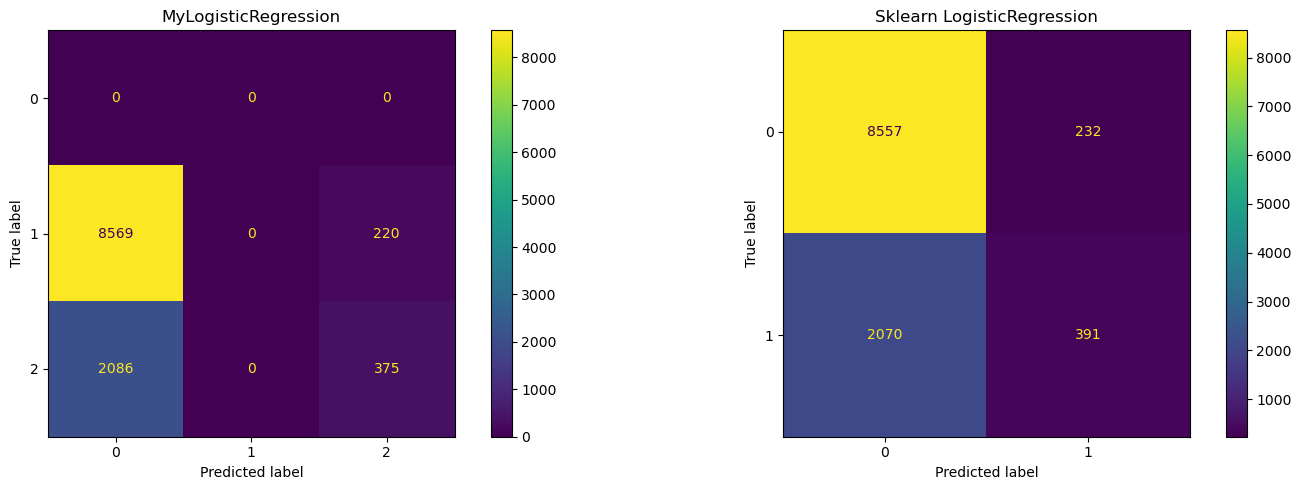

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(confusion_matrix(test_imputed[TARGET], test_imputed['my_predict'])).plot(ax=axes[0])
axes[0].set_title('MyLogisticRegression')
ConfusionMatrixDisplay(confusion_matrix(test_imputed[TARGET], test_imputed['sk_predict'])).plot(ax=axes[1])
axes[1].set_title('Sklearn LogisticRegression')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(test_imputed['my_predict_proba'], bins=50, alpha=0.5, label='My LogReg')
plt.hist(test_imputed['sk_predict_proba'], bins=50, alpha=0.5, label='Sklearn LogReg')
plt.title('Probability Distributions')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_sample = test_imputed.sample(2500)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
cmap = sns.color_palette('ch:', as_cmap=True)
import matplotlib.colors as mcolors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize())
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue=TARGET, 
                         hue_norm=sm.norm, palette=cmap)
plt.colorbar(sm, ax=plt.gca()).set_label('Target')
plt.title('Actual Target Values')

plt.subplot(2, 2, 2)
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='my_predict_proba', 
                         hue_norm=sm.norm, palette=cmap)
plt.colorbar(sm, ax=plt.gca()).set_label('My LogReg Probability')
plt.title('MyLogisticRegression Probabilities')

plt.subplot(2, 2, 3)
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='sk_predict_proba', 
                         hue_norm=sm.norm, palette=cmap)
plt.colorbar(sm, ax=plt.gca()).set_label('Sklearn LogReg Probability')
plt.title('Sklearn LogisticRegression Probabilities')

plt.subplot(2, 2, 4)
# Сравнение бинарных предсказаний
test_sample['my_predict_threshold'] = (test_sample['my_predict_proba'] > 0.5).astype(int)
test_sample['comparison'] = np.where(
    (test_sample['my_predict_threshold'] == test_sample['sk_predict']) & 
    (test_sample['my_predict_threshold'] == test_sample[TARGET]), 
    'Both Correct', 
    np.where(
        (test_sample['my_predict_threshold'] != test_sample['sk_predict']) & 
        (test_sample['my_predict_threshold'] == test_sample[TARGET]), 
        'My Correct', 
        np.where(
            (test_sample['my_predict_threshold'] != test_sample['sk_predict']) & 
            (test_sample['sk_predict'] == test_sample[TARGET]), 
            'Sklearn Correct', 
            'Both Wrong'
        )
    )
)
scatter = sns.scatterplot(data=test_sample, x='loan_amnt', y='loan_int_rate', hue='comparison', 
                         palette={'Both Correct': 'green', 'My Correct': 'blue', 
                                  'Sklearn Correct': 'orange', 'Both Wrong': 'red'})
plt.title('Comparison of Predictions')
plt.legend(title='Prediction Comparison')

plt.tight_layout()
plt.show()


In [ ]:
thresholds = np.linspace(0.01, 0.99, 99)
stats = []

for threshold in thresholds:
    my_pred = (test_imputed['my_predict_proba'] > threshold).astype(int)
    sk_pred = (test_imputed['sk_predict_proba'] > threshold).astype(int)
    
    stats.append({
        'threshold': threshold,
        'my_accuracy': accuracy_score(test_imputed[TARGET], my_pred),
        'sk_accuracy': accuracy_score(test_imputed[TARGET], sk_pred),
        'my_precision': precision_score(test_imputed[TARGET], my_pred, zero_division=0),
        'sk_precision': precision_score(test_imputed[TARGET], sk_pred, zero_division=0),
        'my_recall': recall_score(test_imputed[TARGET], my_pred, zero_division=0),
        'sk_recall': recall_score(test_imputed[TARGET], sk_pred, zero_division=0),
    })

In [ ]:
stats_df = pd.DataFrame(stats)

plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
sns.lineplot(data=stats_df, x='threshold', y='my_accuracy', label='My LogReg Accuracy')
sns.lineplot(data=stats_df, x='threshold', y='sk_accuracy', label='Sklearn LogReg Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid(True)


plt.subplot(3, 1, 2)
sns.lineplot(data=stats_df, x='threshold', y='my_precision', label='My LogReg Precision')
sns.lineplot(data=stats_df, x='threshold', y='sk_precision', label='Sklearn LogReg Precision')
plt.title('Precision vs Threshold')
plt.grid(True)

plt.subplot(3, 1, 3)
sns.lineplot(data=stats_df, x='threshold', y='my_recall', label='My LogReg Recall')
sns.lineplot(data=stats_df, x='threshold', y='sk_recall', label='Sklearn LogReg Recall')
plt.title('Recall vs Threshold')
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
from sklearn.discriminant_analysis import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели на нормированных данных
my_lr_scaled = MyLogisticRegression(lr=0.01)  # Увеличиваем learning rate для нормированных данных
my_lr_scaled.fit(X_train_scaled, y_train, c_epoch=10) #1000

sk_lr_scaled = LogisticRegression(max_iter=1000)
sk_lr_scaled.fit(X_train_scaled, y_train)

# Получение предсказаний
train_imputed['my_scaled_predict_proba'] = my_lr_scaled.predict_proba(X_train_scaled)
test_imputed['my_scaled_predict_proba'] = my_lr_scaled.predict_proba(X_test_scaled)
train_imputed['sk_scaled_predict_proba'] = sk_lr_scaled.predict_proba(X_train_scaled)[:, 1]
test_imputed['sk_scaled_predict_proba'] = sk_lr_scaled.predict_proba(X_test_scaled)[:, 1]

# Сравнение весов
print("\nScaled MyLogisticRegression weights:", my_lr_scaled.weights)
print("Scaled Sklearn LogisticRegression weights:", np.append(sk_lr_scaled.intercept_, sk_lr_scaled.coef_[0]))

# Сравнение ROC AUC
print("\nROC AUC on original data:")
print("My LogReg:", roc_auc_score(test_imputed[TARGET], test_imputed['my_predict_proba']))
print("Sklearn LogReg:", roc_auc_score(test_imputed[TARGET], test_imputed['sk_predict_proba']))

print("\nROC AUC on scaled data:")
print("My LogReg:", roc_auc_score(test_imputed[TARGET], test_imputed['my_scaled_predict_proba']))
print("Sklearn LogReg:", roc_auc_score(test_imputed[TARGET], test_imputed['sk_scaled_predict_proba']))


In [ ]:
# 14. Дополнительное задание: разделение признаков на группы и построение мета-модели
# Предположим группировку признаков:
# Клиентские: person_age, person_income, person_emp_length
# Продуктовые: loan_amnt, loan_int_rate, loan_percent_income
# Кредитная история: cb_person_cred_hist_length, cb_person_default_on_file

# Группируем признаки
# Ensure 'person_emp_length' exists in the DataFrame
if 'person_emp_length' not in train_imputed.columns or 'person_emp_length' not in test_imputed.columns:
    train_imputed['person_emp_length'] = train['person_emp_exp'] if 'person_emp_exp' in train.columns else np.nan
    test_imputed['person_emp_length'] = test['person_emp_exp'] if 'person_emp_exp' in test.columns else np.nan

client_features = ['person_age', 'person_income', 'person_emp_length']
product_features = ['loan_amnt', 'loan_int_rate', 'loan_percent_income']
credit_history_features = ['cb_person_cred_hist_length']

# Создаем и обучаем модели для каждой группы
group_models = {}
group_predictions = {}

for group_name, group_features in [
    ('client', client_features),
    ('product', product_features),
    ('credit_history', credit_history_features)
]:
    # Подготовка данных
    X_train_group = train_imputed[group_features].values
    X_test_group = test_imputed[group_features].values
    
    # Нормируем данные
    scaler = StandardScaler()
    X_train_group_scaled = scaler.fit_transform(X_train_group)
    X_test_group_scaled = scaler.transform(X_test_group)
    
    # Обучаем модель
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_group_scaled, y_train)
    
    # Сохраняем модель
    group_models[group_name] = model
    
    # Получаем предсказания
    train_imputed[f'{group_name}_predict_proba'] = model.predict_proba(X_train_group_scaled)[:, 1]
    test_imputed[f'{group_name}_predict_proba'] = model.predict_proba(X_test_group_scaled)[:, 1]
    
    # Выводим ROC AUC для группы
    print(f"\nROC AUC for {group_name} features:")
    print(roc_auc_score(test_imputed[TARGET], test_imputed[f'{group_name}_predict_proba']))

# Создаем метапризнаки для интегральной модели
meta_features_train = train_imputed[['client_predict_proba', 'product_predict_proba', 'credit_history_predict_proba']].values
meta_features_test = test_imputed[['client_predict_proba', 'product_predict_proba', 'credit_history_predict_proba']].values

# Обучаем интегральную модель
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_features_train, y_train)

# Получаем предсказания интегральной модели
train_imputed['meta_predict_proba'] = meta_model.predict_proba(meta_features_train)[:, 1]
test_imputed['meta_predict_proba'] = meta_model.predict_proba(meta_features_test)[:, 1]

# Выводим ROC AUC для интегральной модели
print("\nROC AUC for meta model:")
print(roc_auc_score(test_imputed[TARGET], test_imputed['meta_predict_proba']))

# Сравниваем ROC AUC всех моделей
print("\nFinal ROC AUC comparison:")
print("Client features:", roc_auc_score(test_imputed[TARGET], test_imputed['client_predict_proba']))
print("Product features:", roc_auc_score(test_imputed[TARGET], test_imputed['product_predict_proba']))
print("Credit history features:", roc_auc_score(test_imputed[TARGET], test_imputed['credit_history_predict_proba']))
print("Meta model:", roc_auc_score(test_imputed[TARGET], test_imputed['meta_predict_proba']))
print("Full feature space (sklearn):", roc_auc_score(test_imputed[TARGET], test_imputed['sk_predict_proba']))

In [ ]:
# 15. Дополнительное задание: влияние размера обучающей выборки на качество модели
sample_sizes = [100, 500, 1000, 2000, 5000, 10000]
roc_auc_scores = []

for size in sample_sizes:
    # Берем подвыборку из тренировочных данных
    train_sample = train_imputed.sample(min(size, len(train_imputed)), random_state=42)
    X_train_sample = train_sample[features].values
    y_train_sample = train_sample[TARGET].values
    
    # Обучаем модель
    lr_sample = LogisticRegression(max_iter=1000)
    lr_sample.fit(X_train_sample, y_train_sample)
    
    # Получаем предсказания на тестовой выборке
    test_imputed[f'sample_{size}_predict_proba'] = lr_sample.predict_proba(X_test)[:, 1]
    
    # Вычисляем ROC AUC
    roc_auc = roc_auc_score(test_imputed[TARGET], test_imputed[f'sample_{size}_predict_proba'])
    roc_auc_scores.append({'sample_size': size, 'roc_auc': roc_auc})

# Строим график зависимости ROC AUC от размера выборки
roc_auc_df = pd.DataFrame(roc_auc_scores)
plt.figure(figsize=(10, 6))
sns.lineplot(data=roc_auc_df, x='sample_size', y='roc_auc', marker='o')
plt.title('ROC AUC vs Training Sample Size')
plt.xlabel('Training Sample Size')
plt.ylabel('ROC AUC on Test Set')
plt.grid(True)
plt.tight_layout()
plt.show()